In [1]:
# include path ../src in order to import modules
import sys
sys.path.append('../src')
import TCT as TCT
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
# Step1: List all the APIs in the translator system
APInames = TCT.list_Translator_APIs()
print(len(APInames))
#print(APInames.keys())

65


In [3]:
# Step 2: Get metaKG from Translator APIs
#metaKG = TCT.get_KP_metadata(APInames) # This only applies to the Translator APIs
#print(metaKG.columns)
#print(metaKG.shape)

#metaKG.to_csv('metaKG.csv', index=False)
metaKG = pd.read_csv('../metaData/metaKG.csv')


In [4]:
# Step 3 (optional): add new metaKG from a user defined API
APInames, metaKG = TCT.add_new_API_for_query(APInames, metaKG, "UserAPI", "http://127.0.0.1:8000/find_path_by_predicate", "biolink:physically_interacts_with", "biolink:Gene", "biolink:Gene")
print(metaKG.shape)

(11244, 5)


In [5]:
query_json = TCT.format_query_json(["NCBIGene:64102"], [], ["biolink:Gene"], ["biolink:Gene"], ["biolink:physically_interacts_with"])
result = TCT.parallel_api_query(list(APInames.values()),query_json=query_json, max_workers=20)
result_parsed = TCT.parse_KG(result)
result_ranked_by_primary_infores = TCT.rank_by_primary_infores(result_parsed, "NCBIGene:64102")

Error: 403
'https://automat.ci.renci.org/drugcentral/1.4/query' generated an exception: HTTPSConnectionPool(host='automat.ci.renci.org', port=443): Max retries exceeded with url: /drugcentral/1.4/query (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x14997c490>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))
Error: 404
Error: 400
Error: 400
Error: 404
Error: 400
Error: 404Error: 500

Error: 404
Error: 404
Error: 500
Error: 404
Error: 404


<AxesSubplot:title={'center':'Ranking of one-hop nodes by predicate'}, ylabel='Predicate'>

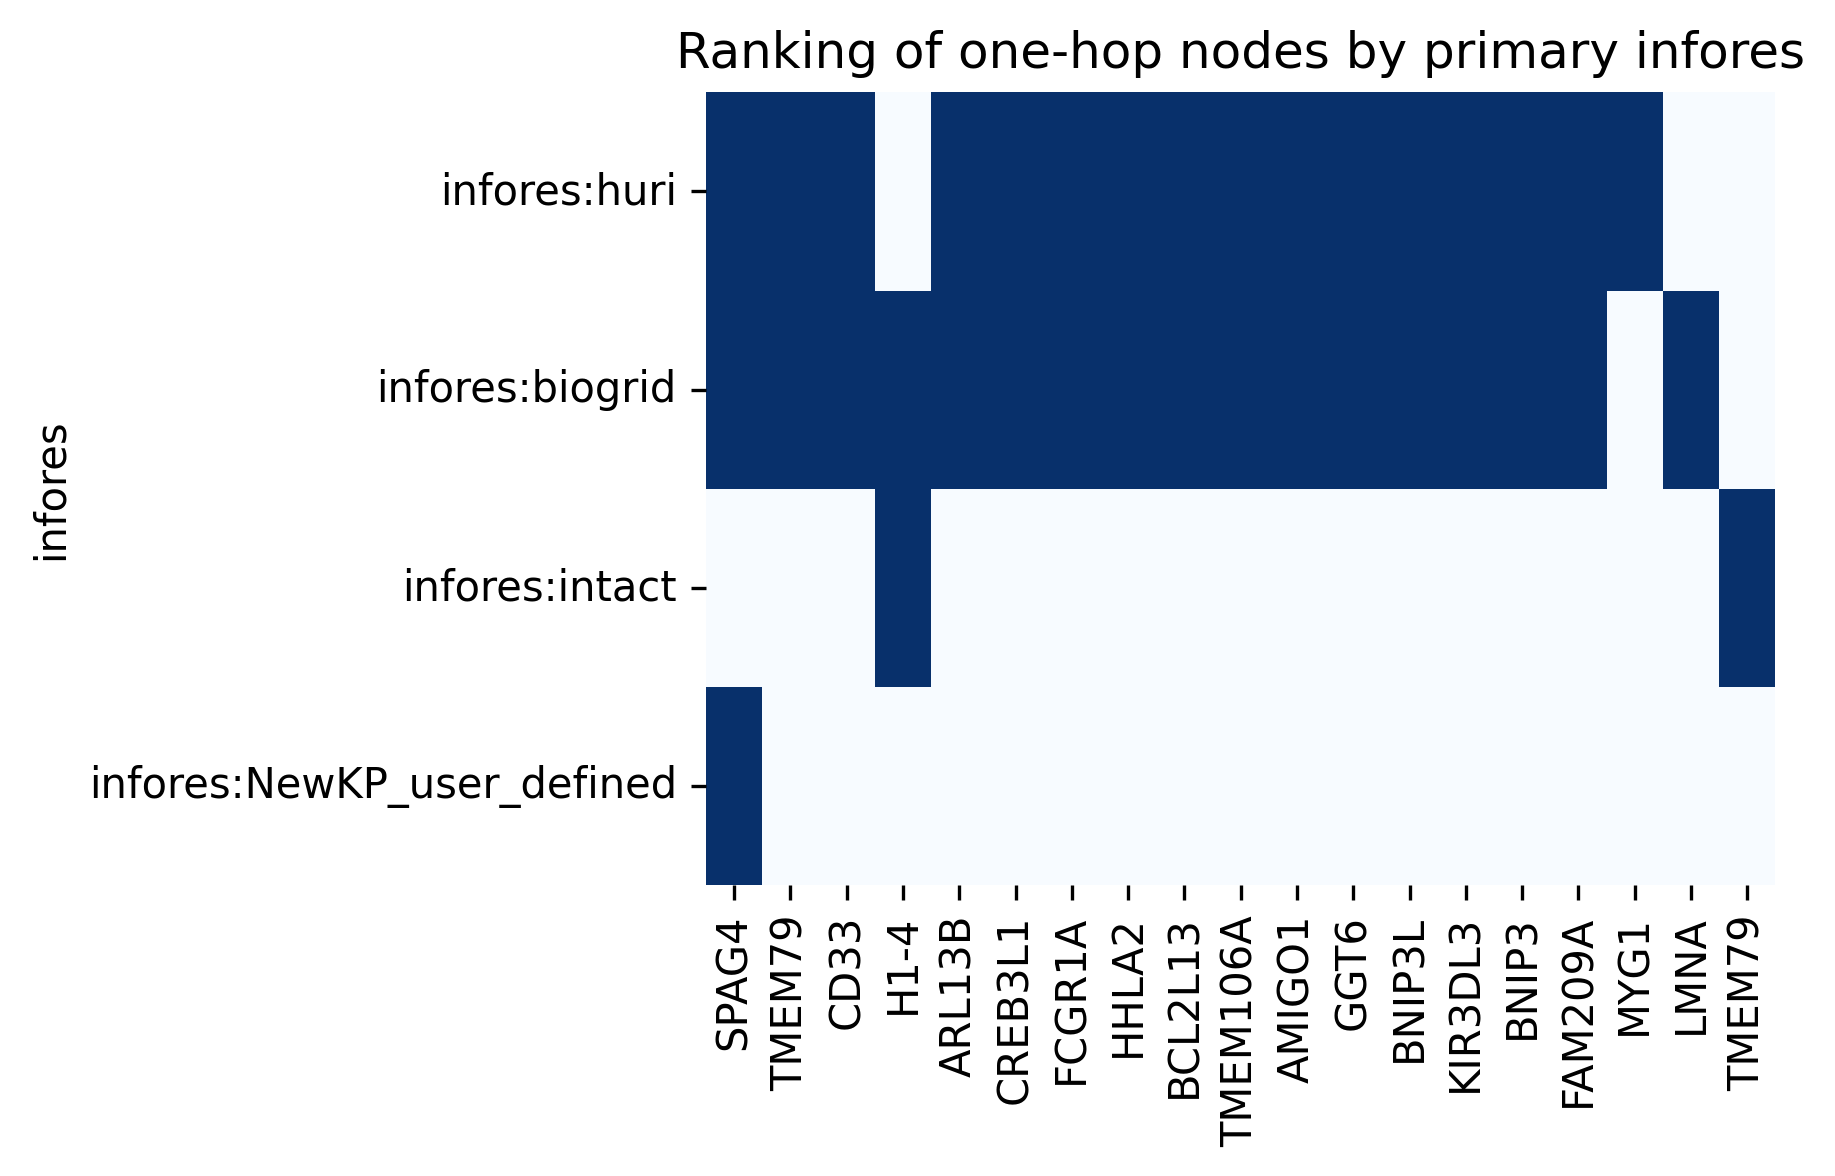

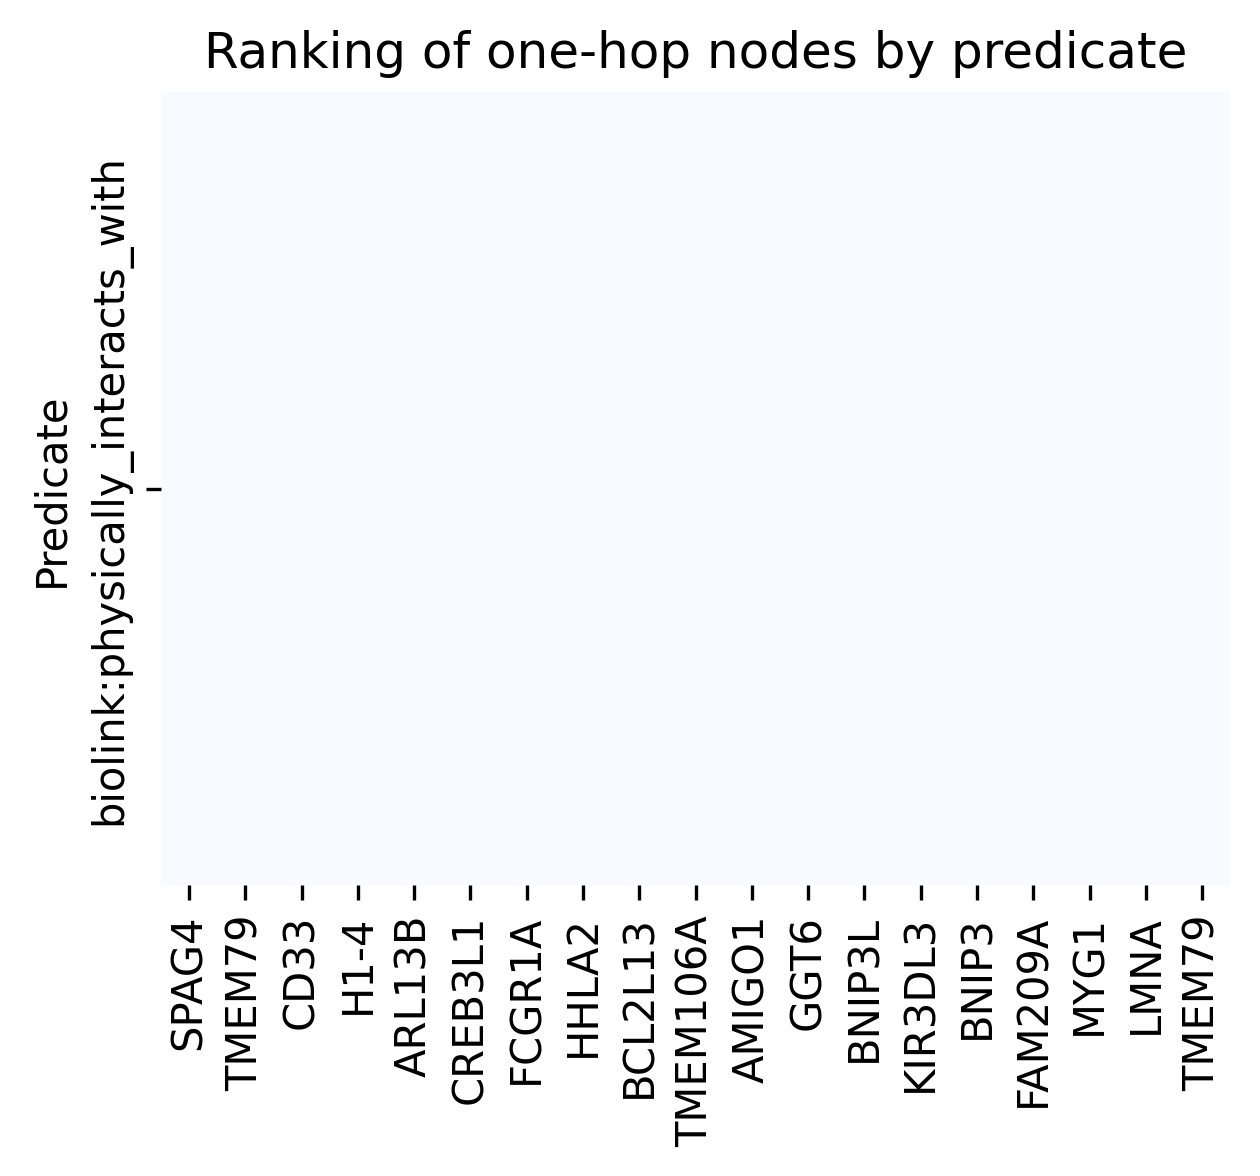

In [6]:
TCT.visulization_one_hop_ranking(result_ranked_by_primary_infores, result_parsed, num_of_nodes = 100, input_query = "NCBIGene:64102")

In [ ]:
# End of the example